In [1]:
%load_ext autoreload
%autoreload 1
%aimport vae
%aimport distributions
%aimport distribution_metrics
%aimport y_utils
%aimport samplers
from y_utils import *
from vae import VAE, get_filename
from samplers import *
from distributions import Banana, Funnel, create_gaussian_lattice
from distribution_metrics import sliced_total_variation, total_variation_1d, wasserstein_metric, coordinate_total_variation
import torch
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from time import time
from tqdm import tqdm
from collections import defaultdict

/home/doctor/venv/data/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cpu


In [3]:
distribution_metric = wasserstein_metric
metric_name = 'Wasserstein Metric'

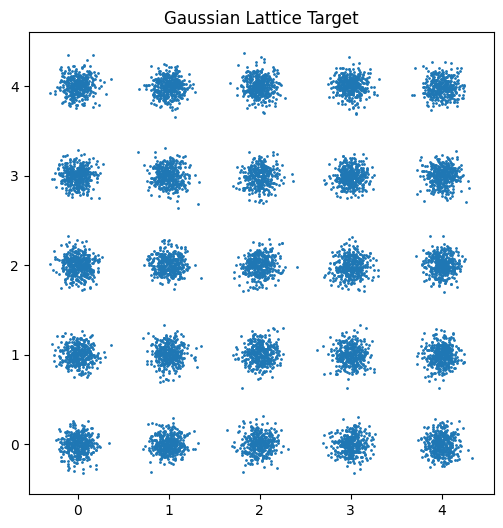

In [4]:
lattice_shape = (5, 5)
target = create_gaussian_lattice(lattice_shape, 1, 0.01)
target_samples = target.sample((10000,))
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(*pl(target_samples), s=1)
ax.set_title('Gaussian Lattice Target');

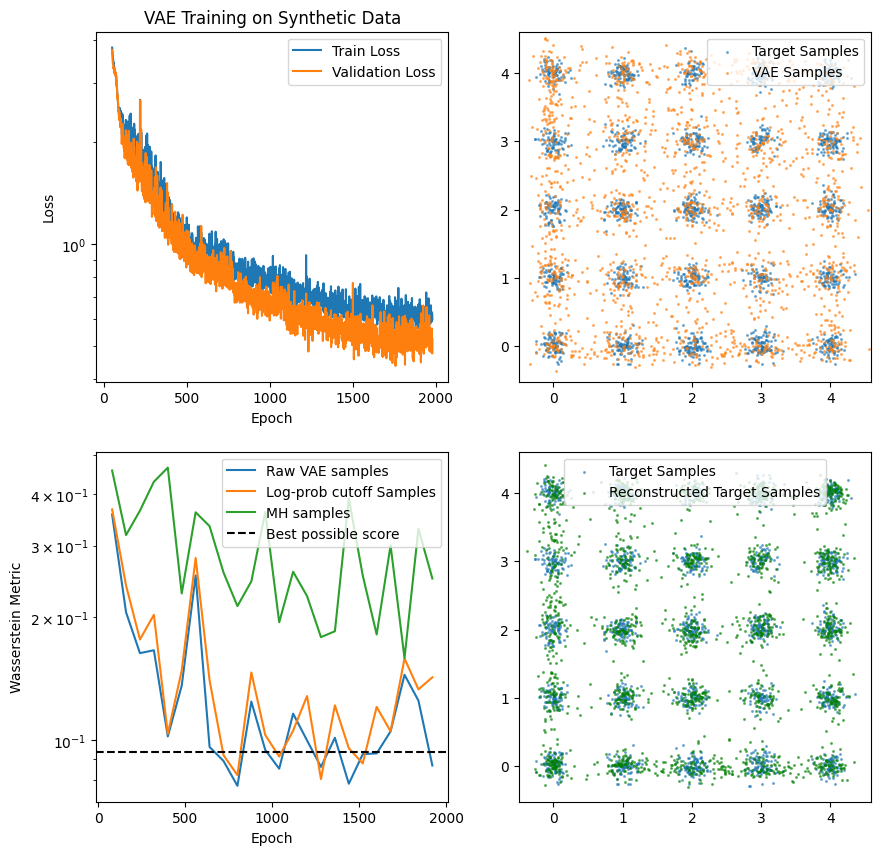

Epoch 1980
	Train loss: 0.6001
	Validation loss: 0.5238
	Learning rate: 3.90625e-06


In [5]:
model = VAE(
    data_dim=len(lattice_shape),
    hidden_dims=(32, 32, 32),
    latent_dim=2,
    device=device
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=100, threshold=1e-3)
model.fit_distribution(
    target, 16_384, optimizer,
    scheduler=scheduler, max_epochs=2000, 
    kl_annealing_epochs=500, batch_size=2_048,
    distribution_metric=distribution_metric
)

In [6]:
L = 64
beta = 1
model_log_prob_estimator = lambda x : model.iw_log_marginal_estimate(x, L=L, beta=beta, batch_L=32)

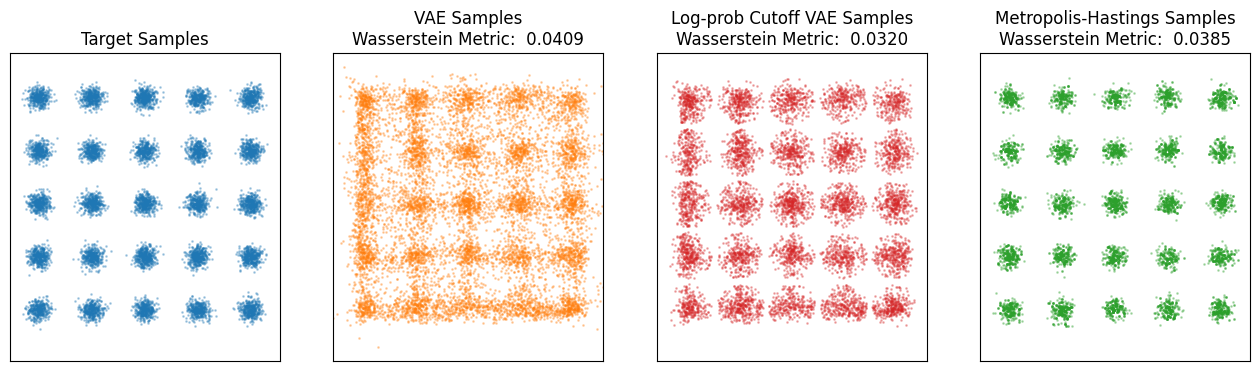

In [7]:
def plot_samples():
    N = 10_000
    q = 0.0
    target_samples = target.sample((N,))
    model_samples = model.sample((N,))
    target_quantile = target.log_prob(target_samples).quantile(q)
    cut_acc_rate, cut_samples = log_prob_cutoff_filter(target, model_samples, target_quantile, return_indicies=False)
    mh_acc_rate, mh_samples = metropolis_hastings_filter(target, cut_samples, model_log_prob_estimator, return_indicies=False)

    def scatter(ax_num, samples, *args, **kwargs):
        axs[ax_num].scatter(*pl(samples), s=1, alpha=0.3, *args, **kwargs)
    fig, axs = plt.subplots(ncols=4, figsize=(16, 4))
    scatter(0, target_samples)
    axs[0].set_title('Target Samples')
    scatter(1, model_samples, color='tab:orange')
    axs[1].set_title(f'VAE Samples\n{metric_name}: {distribution_metric(target_samples, model_samples): 0.4f}')
    scatter(2, cut_samples, color='tab:red')
    axs[2].set_title(f'Log-prob Cutoff VAE Samples\n{metric_name}: {distribution_metric(target_samples, cut_samples): 0.4f}')
    scatter(3, mh_samples, color='tab:green')
    axs[3].set_title(f'Metropolis-Hastings Samples\n{metric_name}: {distribution_metric(target_samples, mh_samples): 0.4f}')
    for ax in axs:
        ax.axis('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(axs[0].get_xlim())
        ax.set_ylim(axs[1].get_ylim())
    #plt.tight_layout()

plot_samples()